In [1]:
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
# import pandas as ps
import time
import re
import os
import shutil
import glob
import math

# from config import config
import data_helpers
from data_generator import *

In [2]:
TEST_ID = 'UK.B.A.11'
TRAIN_PERCENT= 90
BUFFER_SIZE = 20000
BATCH_SIZE = 48
LEARNING_RATE = 0.00001
LOSS_MULTIPLIER = 2.0
TEAM_EMBS = 50
LOSS_RAMBDA = 0.5
NORM_PP_PATIENCY = 100
MAE_NOT_MSE_LOSS = True
TRANSFORMER_DROP = 0.2
TRANSFORMER_LAYERS = 6
TRANSFORMER_HEADS = 6
# ADAPTORS_LAYERS = 10
RESET_HISTORY = False
MIN_PROFIT = -0.10
DISTRIBUTION_KEYS = [2.0, 1.0, 0.5, 0.0, -0.5, -1.0]
MIN_PROFIT_P_PER_GAME_PER_QGROUP = 0.5
id_to_ids_filename = 'England-200-1e-07-7300-75-0.8-False'

In [3]:
countryDirPath = "./data/football-data-co-uk/England"
df = data_helpers.get_master_df_from_football_data_co_uk(countryDirPath)

In [4]:
tokenizer_team = creat_team_tokenizer_uk(df)
print(tokenizer_team.get_vocab_size())

teams = ['Tottenham', 'Arsenal', 'Liverpool', 'what?', 'Tottenham', 'Chelsea', 'e_t', 'Man United', '1234', '[HOME]', '[AWAY]']
teams = [team.strip() for team in [re.sub(r"\s", "_", item) for item in teams]]
teams = " ".join(teams)
encoding = tokenizer_team.encode(teams)
# encoding = tokenizer.encode("")
print(encoding.tokens)
print(encoding.type_ids)
print(encoding.ids)

tokenizer_team.decode(encoding.ids)

113
['tottenham', 'arsenal', 'liverpool', '[UNK]', 'tottenham', 'chelsea', '[UNK]', 'man_united', '[UNK]', '[UNK]', '[UNK]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[101, 4, 58, 0, 101, 27, 0, 62, 0, 0, 0]


'tottenham arsenal liverpool tottenham chelsea man_united'

In [5]:
class hyperparams:    
    nDivisions = 4 + 1  # E0, E1, E2, E3, and Unknown
    division_embs = 4
    nTeams = tokenizer_team.get_vocab_size()    # including Unknown
    team_embs = TEAM_EMBS
    nGoals  = 10  # 0 for 0 goals not for Unknown.
    goal_embs = 4
    nResults = 4    # HWin, Draw, AWin, and Unknown
    result_embs = 4
    # Mate d_model an even number!!!
    d_model = get_std_size()    + division_embs * len(Div_cols) + team_embs * len(Team_cols) \
                                + goal_embs * len(Goal_cols) + result_embs * len(Result_cols)
    batch_size = BATCH_SIZE
    days_spanning_years = 30
    num_layers = TRANSFORMER_LAYERS
    num_heads = TRANSFORMER_HEADS
    m365_size = 1
    initial_m365 = 0.9
    # d_model = team_emb_size * 2 + country_emb_size * 3 + odds_size + outcome_size

In [6]:
filepath = os.path.join(os.getcwd(), 'data', 'id_to_ids', id_to_ids_filename + '.json')
id_to_ids = data_helpers.LoadJsonData(filepath)

In [ ]:
lengths = [len(ids) for (tag, label, ids) in id_to_ids.values()]
maxLen = max(lengths)
plt.hist(lengths, np.linspace(0, int(maxLen*1.1), int(maxLen*1.1) + 1))
plt.ylim(plt.ylim())
maxLen = max(lengths)
# plt.plot([maxLen, maxLen], plt.ylim())
plt.title(f'Max length of ids: {maxLen}')

MAX_TOKENS = maxLen

In [8]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA']
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Result_cols = ['HTR', 'FTR']    # A function of Goal_cols, but contribute to better representation.
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
Red_cols = ['HR', 'AR']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

# underscore_prefixed lists have discontinued columns.
BBAB_cols = BB_cols + AB_cols
_Cols_List_to_Embedd = [Div_cols, Team_cols, Goal_cols, Result_cols]
_Cols_List_to_Standardize = [Odds_cols, Shoot_cols, ShootT_cols, Corner_cols, Faul_cols, Yellow_cols, Red_cols]
_Cols_List_for_Label = [Full_Goal_cols, Odds_cols]
_Label_cols = Full_Goal_cols + Odds_cols

BBAB_cols = BB_cols + AB_cols
base_bbab = list(df.loc[df['id'] == 100000, BBAB_cols].iloc[0, :])
print(base_bbab)

[100000, 'E0', datetime.date(2004, 1, 11), 'Man_City', 'Norwich', 1.72, 3.4, 5.0, 1.7, 3.2, 5.0, 1.65, 3.3, 4.4, 1.66, 3.1, 5.0, 1.0, 0.0, 1, 1, 'H', 'D', 19.0, 10.0, 11.0, 5.0, 9.0, 4.0, 10.0, 13.0, 1.0, 0.0, 0.0, 0.0]


In [9]:
std_path = os.path.join('./data', 'datasets', id_to_ids_filename + ".json")
std_params = get_standardization_params(df)
print(std_params)
data_helpers.SaveJsonData(std_params, std_path)
std_params = data_helpers.LoadJsonData(std_path)

{'B365H': (3.1630270400481795, 1.4687447460469159, 46.0), 'HS': (11.39694154084398, 4.709404811489129, 43.0), 'HST': (4.815343915343916, 2.759941394538306, 24.0), 'HC': (5.34632855852368, 2.842282967456132, 24.0), 'HF': (11.421925409730287, 3.7612036770331043, 77.0), 'HY': (1.5455413601755066, 1.2348960213340971, 11.0), 'HR': (0.08013937282229965, 0.2855927650445304, 3.0)}


In [10]:
ds_path = os.path.join('./data', 'datasets', id_to_ids_filename)

# ds = generate_dataset_uk(df, id_to_ids, tokenizer_team, std_params)
# tf.data.Dataset.save(ds, ds_path)

ds = tf.data.Dataset.load(ds_path)
len(ds)

38745

In [11]:
dataset_size = len(ds)
train_size = int(TRAIN_PERCENT/100 * dataset_size)
test_size = dataset_size - train_size

train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)

print(len(train_ds), len(test_ds), len(ds), len(ds)-len(train_ds)-len(test_ds))

34870 3875 38745 0


In [12]:
dummy_bbas_tensor = get_dummy_bbas_tensor_uk(df, tokenizer_team, std_params)

In [13]:
def normalize_row(baseId, sequence, base_bb, base_label):
    try:
        seq_len_org = sequence.shape[0]
        nMissings = MAX_TOKENS - seq_len_org
        if nMissings > 0:
            block = tf.stack([dummy_bbas_tensor] * nMissings, axis=0)
            sequence = tf.concat([sequence, block], axis=0) 
        # print("sequence 1", sequence.shape)
        # sequence[:, 2] = base[2] - sequence[:, 2]   # get delta days.
        base_bb = base_bb[tf.newaxis, :]    # shape: (seq_len = 1, nFeatures)
        mask = tf.Variable([1] * seq_len_org + [0] * nMissings, dtype=tf.int32) ## DO NOT USE tf.constant !!! unstable.
        mask = mask[:, tf.newaxis] & mask[tf.newaxis, :]
        # print('normalize', sequence.shape, base.shape, mask.shape, mask)
        # seq_len_org = tf.Variable(seq_len_org, dtype=tf.int32)    #--------------------------------- comeback
        return (baseId, sequence, base_bb, base_label, mask, seq_len_org)
    except:
        print('normalize_row exception')
        print('norm 1', sequence.shape, base_bb.shape, base_label.shape, mask.shape, nMissings)
        print('norm 2', baseId, sequence, base_label, mask, nMissings)
        # return (baseId, sequence, base_bb, base_label, mask, seq_len_org)

def prepare_batch(baseId, sequence, base_bb, base_label, mask, seq_len_org):
    # target = tf.one_hot(tf.squeeze(tf.cast(base_bbab[:, :, -1], dtype=tf.int32), axis=-1), hyperparams.target_onehot_size)
    return (baseId, sequence, base_bb, mask), (base_label, seq_len_org)     # (X, Y)

def normalize_dataset(ds):
    return (
        ds.map(lambda baseId, sequence, base_bb, base_label: tf.py_function(
            func=normalize_row,
            inp=[baseId, sequence, base_bb, base_label],
            Tout=[tf.int32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32])) #, tf.data.AUTOTUNE == Instability!!!
        )

def make_train_batches(ds):
    return (
        ds
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

def make_test_batches(ds):
    return (
        ds
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

In [14]:
train_ds_path = os.path.join('./data', 'datasets', id_to_ids_filename + '_train_' + str(TRAIN_PERCENT))
if os.path.exists(train_ds_path):
    train_ds = tf.data.Dataset.load(train_ds_path)
else:
    train_ds = normalize_dataset(train_ds)
    tf.data.Dataset.save(train_ds, train_ds_path)

train_batches = make_train_batches(train_ds)

In [15]:
test_ds_path = os.path.join('./data', 'datasets', id_to_ids_filename + '_test_' + str(TRAIN_PERCENT))
if os.path.exists(test_ds_path):
    test_ds = tf.data.Dataset.load(test_ds_path)
else:
    test_ds = normalize_dataset(test_ds)
    tf.data.Dataset.save(test_ds, test_ds_path)

test_batches = make_test_batches(test_ds)

In [16]:
def positional_encoding(memory, depth):
    positions = tf.range(memory.shape[-1], dtype=tf.float32)
    fractional_pos = memory * positions    # fractional position: (batch, fractional position #)
    depth = depth/2
    depths = tf.range(depth, dtype=tf.float32) / depth
    depths = tf.pow(10000.0, depths)    # (depth,)
    angle_rads = fractional_pos[:, :, tf.newaxis] / depths  # (batch, fractional position #, depth)
    # pos_encoding = rearrange([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], 'w b p d -> w h (w t)')
    pos_encoding = tf.concat([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], axis=-1)
    return pos_encoding

In [ ]:
memory = tf.ones((100, 200), dtype=tf.float32) * 0.5
pos_encoding = positional_encoding(memory, depth=512)
# print('pos_encoding', pos_encoding.shape)
pos_encoding = pos_encoding[0, :, :]
# print(pos_encoding.shape)
# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [18]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA']
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Result_cols = ['HTR', 'FTR']    # A function of Goal_cols, but contribute to better representation.
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
Red_cols = ['HR', 'AR']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

In [19]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, hyperparams, isEncoder=True):
    super().__init__()
    self.isEncoder = isEncoder
    self.division_embedding = tf.keras.layers.Embedding(hyperparams.nDivisions, hyperparams.division_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown
    self.team_embedding = tf.keras.layers.Embedding(hyperparams.nTeams, hyperparams.team_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown
    self.goal_embedding = tf.keras.layers.Embedding(hyperparams.nGoals, hyperparams.goal_embs, dtype=tf.float32, mask_zero=False) # Learn 0-goal
    self.result_embedding = tf.keras.layers.Embedding(hyperparams.nResults, hyperparams.result_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown

    self.d_model = hyperparams.d_model
    # print(self.d_model)
    self.position_permuting_dense = tf.keras.layers.Dense(self.d_model)
    self.m365_embedding = tf.keras.layers.Embedding(1, hyperparams.m365_size, mask_zero=False, embeddings_initializer = tf.keras.initializers.Ones())

    self.idx_Days = BB_cols.index('Date')
    assert self.idx_Days == BBAB_cols.index('Date')

  def call(self, x):
    (sequence, base_bb, mask) = x # sob = sequence or base_bb
    sDays = sequence[:, :, self.idx_Days]
    bDays = base_bb[:, :, self.idx_Days]
    
    # BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols
    # AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

    sob = None
    if self.isEncoder:
      sob = sequence
    else:
      sob = base_bb

    if self.isEncoder:
      # Extract odds to remove them
      id, div, days, teams, odds, goals, results, remainder \
      = tf.split(sob, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), len(Goal_cols), len(Result_cols),  -1], axis=-1)
      # print('1', remainder[0, 0])
    else:
      # Extract odds to remove them
      id, div, days, teams, odds, remainder \
      = tf.split(sob, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), -1], axis=-1)  
      # print('2', remainder[0, 0])  

    # print('pe 2.7.1 1', div)
    div = self.division_embedding(tf.cast(div, dtype=tf.int32))
    div = tf.reshape(div, [div.shape[0], div.shape[1], -1])
    # print('pe 2.7.1 1', div)
    teams = self.team_embedding(tf.cast(teams, dtype=tf.int32))
    teams = tf.reshape(teams, [teams.shape[0], teams.shape[1], -1])
    if self.isEncoder:
      goals = self.goal_embedding(tf.cast(goals, dtype=tf.int32))
      goals = tf.clip_by_value(goals, 0, hyperparams.nGoals)
      goals = tf.reshape(goals, [goals.shape[0], goals.shape[1], -1])
      results = self.result_embedding(tf.cast(results, dtype=tf.int32))
      results = tf.reshape(results, [results.shape[0], results.shape[1], -1])
    
    if self.isEncoder:
      concat = [div, teams, goals, results, odds, remainder]
    else:
      concat = [div, teams, odds, remainder]

    sob = tf.concat(concat, axis=-1)
    sob = self.position_permuting_dense(sob)

    days_ago = tf.cast(bDays - sDays, dtype=tf.float32) if self.isEncoder else tf.cast(bDays - bDays, dtype=tf.float32)
    
    m365 = self.m365_embedding(tf.zeros_like((hyperparams.m365_size,), dtype=tf.float32)) * hyperparams.initial_m365  # expected shape: (1, hyperparams.remain_365_size)
    m365 = tf.squeeze(m365, axis=0)
    memory_alpha = tf.math.pow(m365, 1.0/365) # (hyperparams.m365_size,)
    memory = tf.math.pow(memory_alpha, days_ago[:, :, tf.newaxis])  # decrease as days_ago increase, if memory <= 1.0 as expected.
    memory = tf.reduce_mean(memory, axis=-1)

    pe = positional_encoding(memory, depth=sob.shape[-1]) # (batch, d_model)
    pe = pe / tf.math.sqrt(tf.cast(sob.shape[-1], tf.float32))
    sob = sob + pe

    if self.isEncoder:
      mask = mask
    else:
      mask = mask[:, 0:sob.shape[1], :]

    return (sob, mask)

In [20]:
pos = PositionalEmbedding(hyperparams, isEncoder=True)

cnt = 2
for z in train_batches:
    (baseId, sequence, base_bb, mask), (base_label, seq_len_org) = z
    cnt -= 1
    if cnt == 0: break
# print('baseId', baseId)
sample_x = (sequence, base_bb, mask)
eSob, eMask = pos.call(sample_x)
print(eSob.shape, eMask.shape)

(48, 200, 152) (48, 200, 200)


In [21]:
PE = PositionalEmbedding(hyperparams, isEncoder=True)
eSob, eMask = PE(sample_x)
print(eSob.shape, eMask.shape )
del PE

(48, 200, 152) (48, 200, 200)


In [22]:
PE = PositionalEmbedding(hyperparams, isEncoder=False)
dSob, dMask = PE(sample_x)
print(dSob.shape, dMask.shape )
del PE

(48, 1, 152) (48, 1, 200)


In [23]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
      super().__init__()
      self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
      self.layernorm = tf.keras.layers.LayerNormalization()   # So the default -1 axix is normalized across. No inter-token operatoin.
      self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context, mask):
      attn_output, attn_scores = self.mha(
          query=x,
          key=context,
          value=context,
          attention_mask=mask,
          return_attention_scores=True)
    
      # Cache the attention scores for plotting later.
      self.last_attn_scores = attn_scores
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
  
class GlobalSelfAttention(BaseAttention): 
    def call(self, x, mask):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x,
          attention_mask=mask)    # intentional inter-token operation
      x = self.add([x, attn_output])  # token-wise
      x = self.layernorm(x)         # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class CausalSelfAttention(BaseAttention): # mask-agnostic
    def call(self, x):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x,
          use_causal_mask = True)     # look-over mask is generagted and used, in decoder layers
      x = self.add([x, attn_output])  # mask-agnostic
      x = self.layernorm(x)  # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),    # across -1 axis
        tf.keras.layers.Dense(d_model),    # across -1 axis
        tf.keras.layers.Dropout(dropout_rate)    # mask-agnostic
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      x = self.add([x, self.seq(x)])  # mask-agnostic
      x = self.layer_norm(x)  # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
      super().__init__()

      self.self_attention = GlobalSelfAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)

      self.ffn = FeedForward(d_model, dff)

    def call(self, x, mask):
      # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.self_attention(x, mask)
      x = self.ffn(x)
      return x
  
class Encoder(tf.keras.layers.Layer):
    def __init__(self, hyperparams, dropout_rate=0.1):
      super().__init__()

      self.d_model = hyperparams.d_model
      self.num_layers = hyperparams.num_layers

      self.pos_embedding = PositionalEmbedding(hyperparams)

      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.enc_layers = [
          EncoderLayer(d_model=hyperparams.d_model,
                      num_heads=hyperparams.num_heads,
                      dff=hyperparams.d_model * 4,
                      dropout_rate=dropout_rate)
          for _ in range(hyperparams.num_layers)]

    def call(self, x):
      # x = (sequence, base_bb, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (token, max_tokens, max_tokens)
      x, mask = self.pos_embedding(x)  # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.dropout(x)
      for encoder_layer in self.enc_layers:
        x = encoder_layer(x, mask)
      return x  # Shape `(batch_size, seq_len, d_model)`.
  
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
      super(DecoderLayer, self).__init__()

      self.causal_self_attention = CausalSelfAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)
      
      self.cross_attention = CrossAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)

      self.ffn = FeedForward(d_model, dff)

    def call(self, x, context, cross_attention_mask):
      # x: (batch, 1, d_model), context: (batch, max_tokens, d_mode)
      x = self.causal_self_attention(x=x)
      x = self.cross_attention(x, context, cross_attention_mask)

      # Cache the last attention scores for plotting later
      self.last_attn_scores = self.cross_attention.last_attn_scores

      x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
      return x
  
class Decoder(tf.keras.layers.Layer):
    def __init__(self, hyperparams, dropout_rate=0.1):
      super(Decoder, self).__init__()

      self.d_model = hyperparams.d_model
      self.num_layers = hyperparams.num_layers

      self.pos_embedding = PositionalEmbedding(hyperparams, isEncoder=False)

      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.dec_layers = [
          DecoderLayer(d_model=hyperparams.d_model, num_heads=hyperparams.num_heads,
                      dff=hyperparams.d_model * 4, dropout_rate=dropout_rate)
          for _ in range(hyperparams.num_layers)]

      self.last_attn_scores = None

    def call(self, x, context):
      # x = (sequence, base_bb, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (token, max_tokens, max_tokens)
      # context: (batch, max_tokens, d_model)
      # `x` is token-IDs shape (batch, target_seq_len)
      x, ca_mask = self.pos_embedding(x)  # x: (batch, 1, d_model), ca_mask: (batch, 1, max_tokens)     
      x = self.dropout(x)
      for decoder_layer in self.dec_layers:
        x  = decoder_layer(x, context, ca_mask)
      self.last_attn_scores = self.dec_layers[-1].last_attn_scores
      return x
  
class Transformer(tf.keras.Model):
    def __init__(self, hyperparams, dropout_rate=0.1):
      super().__init__()
      self.encoder = Encoder(hyperparams, dropout_rate=dropout_rate)

      self.decoder = Decoder(hyperparams, dropout_rate=dropout_rate)

      self.final_layer = tf.keras.layers.Dense(hyperparams.d_model) #-------------- to modify

    def call(self, inputs):
      # inputs = (sequence, base_bb, mask)
      # sequence: (batch, max_token, aabb), base: (batch, 1, bb), mask: (batch, max_token, max_token)
      x = self.encoder(inputs)  # (batch, max_tokens, d_model)
      x = self.decoder(inputs, x)  # (batch, 1, d_model)
      logits = self.final_layer(x)  # (batch, 1, d_model)
      logits = tf.squeeze(logits, axis=-2)  # (batch, d_model)
      return logits

In [24]:
sample_transformer = Transformer(hyperparams)
y = sample_transformer(sample_x)

sample_transformer.summary()
del sample_transformer

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  4490487   
                                                                 
 decoder (Decoder)           multiple                  7831087   
                                                                 
 dense_29 (Dense)            multiple                  23256     
                                                                 
Total params: 12,344,830
Trainable params: 12,344,830
Non-trainable params: 0
_________________________________________________________________


In [25]:
class Adaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [hyperparams.d_model + round( (d_output - hyperparams.d_model) * (layer+1) / (nLayers) ) for layer in range(nLayers)]
    layers = [tf.keras.layers.Dense(dim, activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x

In [26]:
class QGroup(tf.keras.Model):
  softmax = tf.keras.layers.Softmax(axis=-1)
  scalar_product = tf.keras.layers.Dot(axes=(-1, -1))

  def __init__(self, bookie, nQueries, dropout_rate=0.1):
    super().__init__()
    self.bookie = bookie
    self.nQueries = nQueries
    self.bookieBase = Adaptor(5, self.nQueries) # 55555555555555555555555
    self.oh_1 = Adaptor(5, self.nQueries)       # 55555555555555555555555
    return

  def call(self, input):
    # inputs.shape: (batch, d_model)
    base = self.bookieBase(input)        # (batch, nQueries)
    stake_p = QGroup.softmax(base)            # (batch, nQueries)
    oh_1_p = self.oh_1(base)                  # (batch, nQueries)
    return (oh_1_p, stake_p)  # (batch, 3), (batch, nQueries) 

  #------------------------------- call used in UK.B.A.01 -------------------------  
  # def call(self, input):
  #   # inputs.shape: (batch, d_model)
  #   base = self.bookieBase(input)        # (batch, nQueries)
  #   stake_p = QGroup.softmax(base)            # (batch, nQueries)
  #   oh_1_p = self.oh_1(base)                  # (batch, nQueries)
  #   profit_p = tf.math.multiply(oh_1_p, stake_p)   # (batch, nQueries)
  #   return (profit_p, stake_p)  # (batch, nQueries), (batch, nQueries) 

  #------------------------------- call in UK.B.A.02, this version -----------
  # def call(self, input):
  #   # inputs.shape: (batch, d_model)
  #   base = self.bookieBase(input)             # (batch, nQueries)
  #   stake_p = QGroup.softmax(base)            # (batch, nQueries)
  #   oh_1_p = self.oh_1(base)                  # (batch, nQueries)
  #   profit_p = self.scalar_product([oh_1_p, stake_p]) # (batch, 1)
  #   return (profit_p, stake_p)  # (batch, 1), (batch, nQueries) 
  
  #------------------------------- call in UK.B.A.03, a futrue version -----------
  # # profit_p is free and independent of stake_p
  # def call(self, input):
  #   # inputs.shape: (batch, d_model)
  #   base = self.bookieBase(input)             # (batch, nQueries)
  #   stake_p = QGroup.softmax(base)            # (batch, nQueries)
  #   profit_p = self.profit(base)              # (batch, 1)
  #   return (profit_p, stake_p)  # (batch, 1), (batch, nQueries) 

  #----- ToDo: replace self.scalar_product layer with a tf scalar product function, for speed.
  def h_true(self, ftGoals):  # Defines this QGroup. This is for 1X2 QGroup. Derived classes re-define this funciton.
    # ftGoals:  (batch, 2)
    ftGoals = tf.cast(ftGoals, dtype=tf.int32)  # (batch, 2)
    h = (tf.math.greater(ftGoals[..., 0], ftGoals[..., 1]), tf.math.equal(ftGoals[..., 0], ftGoals[..., 1]), tf.math.less(ftGoals[..., 0], ftGoals[..., 1]))
    h = tf.cast(tf.transpose(h), dtype=tf.float32)  # (batch, nQueries)
    return h

  def profit_true(self, ftGoals, odds):
    stake_t = self.h_true(ftGoals)  # (batch, nQueries)
    oh_1_true = tf.math.multiply(odds, self.h_true(ftGoals)) - 1.0  # (batch, nQueries)
    profit_t = self.scalar_product([oh_1_true, stake_t])  # (batch, 1)
    return profit_t

  #-------------------- THis loss is NOT used in action versions.
  def loss(self, profit_p, stake_p, ftGoals, odds, rambda):
    # profit_p: (batch, 1)
    # stake_p:  (batch, nQueries)
    # ftGoals:  (batch, 2)
    # odds:     (batch, nQueries)
    # rambda:   ()
    profit_t = self.profit_true(ftGoals, odds)  # (batch, 1)
    if MAE_NOT_MSE_LOSS:
        profit_p_err = tf.reduce_mean(tf.math.abs(profit_t - profit_p), axis=None) # (), profit dimention.
    else:
        profit_p_err = tf.reduce_mean(tf.math.pow(profit_t - profit_p, 2.0), axis=None) # (), profit dimention.

    oh_1_t = tf.math.multiply(odds, self.h_true(ftGoals)) - 1.0   # (batch, nQueries)
    profit_back = self.scalar_product([oh_1_t, stake_p])    # (batch, 1)
    profit_back = tf.reduce_mean(profit_back, axis=None)    # ()
    loss = (1.0-rambda) * profit_p_err - profit_back * rambda # ()
    return loss # ()
  
  def oh_1_loss(self, oh_1_p, ftGoals, odds):
    # oh_1_p: (bacth, nQueries)
    h_true = self.h_true(ftGoals)
    oh_1_t = tf.multiply(odds, h_true)  # (batch, nQueries)
    if MAE_NOT_MSE_LOSS:
        profit_p_err = tf.reduce_mean(tf.math.abs(oh_1_t - oh_1_p), axis=-1) # (batch, ), profit dimention.
    else:
        profit_p_err = tf.reduce_mean(tf.math.pow(oh_1_t - oh_1_p, 2.0), axis=-1) # (batch, ), profit dimention.
    
    return profit_p_err # (batch, )

  #--------------------------------------- Used as profit_back_with_batch in UK.B.A.01
  def profit_eval(self, ftGoals, odds, stake_p):
    oh_1_t = tf.math.multiply(odds, self.h_true(ftGoals)) - 1.0
    profit_e = QGroup.scalar_product([oh_1_t, stake_p])
    return profit_e   # (batch, 1)

  #-------------------------------------- The same as 'profit_eval' above --------------
  def profit_back_with_batch(self, ftGoals, odds, stake_p):
    oh_1_t = tf.math.multiply(odds, self.h_true(ftGoals)) - 1.0
    profit_back = self.scalar_product([oh_1_t, stake_p])    # (batch, 1)
    return profit_back

In [27]:
a = tf.constant([[3.0, 3.0, 4.0], [0.1, 0.7, 0.3]])
one_hot_a = tf.squeeze(tf.one_hot(tf.nn.top_k(a).indices, tf.shape(a)[-1]), axis=1)
print(one_hot_a)

tf.Tensor(
[[0. 0. 1.]
 [0. 1. 0.]], shape=(2, 3), dtype=float32)


In [28]:
class QGroup1X2(QGroup):
  def __init__(self, bookie, dropout_rate=0.1):
    super().__init__(bookie=bookie, nQueries=3, dropout_rate=dropout_rate)
    self.qGroupName = '1X2'

  def h_true(self, ftGoals):  # Defines this QGroup. This is for 1X2 QGroup.
    # ftGoals:  (batch, 2)
    ftGoals = tf.cast(ftGoals, dtype=tf.int32)  # (batch, 2)
    h = (tf.math.greater(ftGoals[..., 0], ftGoals[..., 1]), tf.math.equal(ftGoals[..., 0], ftGoals[..., 1]), tf.math.less(ftGoals[..., 0], ftGoals[..., 1]))
    h = tf.cast(tf.transpose(h), dtype=tf.float32)  # (batch, nQueries)
    return h

In [29]:
class BettingEPL(tf.keras.Model):
  def __init__(self, hyperparams, loss_rambda=1.0, dropout_rate=0.1):
    super().__init__()
    self.transformer = Transformer(hyperparams, dropout_rate=dropout_rate)
    self.bookies = ['B365', 'Betfair', 'Interwetten', 'William']
    self.qGroups = [QGroup1X2(bookie) for bookie in self.bookies]
    self.rambda = loss_rambda     #----------------------- Sensitive rambda!!!, Automate optimizing it.
    # self.shift_embedding = tf.keras.layers.Embedding(1, hyperparams.m365_size, mask_zero=False, embeddings_initializer = tf.keras.initializers.Ones())
    # self.shift = None

  def call(self, input):
      x = self.transformer(input)
      outputs = [qGroup(x) for qGroup in self.qGroups]
      # self.shift = tf.squeeze(self.shift_embedding(0))  # squeeze((1, 1)) = ()
      return outputs  # [ ( shape: (batch, 1), shape: (batch, nQueries) ) for _ in self.qGroups ]
  
  def loss(self, y, outputs):   
      # y: (batch, len(Team_cols)+len(Odds_cols)) 
      # outputs: # [ ( profit_p: (batch, 1), stake_p: (batch, nQueries) ) for _ in self.qGroups ]
      ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, sum[qGropu.nQueries for qGroup in self.qGroups])
      odds_by_qGroup = tf.split(odds, [qQroup.nQueries for qQroup in self.qGroups], axis=-1)  # [ shape: (batch, qGroup.nQueries) for qGroup in self.qGroups ]
      losses = [qGroup.loss(profit_p, stake_p, ftGoals, odds, self.rambda) for (qGroup, odds, (profit_p, stake_p)) in zip(self.qGroups, odds_by_qGroup, outputs)]
      # losses: [()] * nQGroup
      losses = tf.stack(losses, axis=0) # (nQGroups,)
      loss_value = tf.math.mean_reduce(losses, axis=None)
      return loss_value
  
  def profit_back_over_qGroups(self, y, outputs):
      # y: (batch, len(Team_cols)+len(Odds_cols)) 
      # outputs: # [ ( oh_1_p: (batch, nQueries), stake_p: (batch, nQueries) ) for _ in self.qGroups ]
      ftGoals, odds = tf.split(y, [2, -1], axis=-1)
      odds_by_qGroup = tf.split(odds, [qQroup.nQueries for qQroup in self.qGroups], axis=-1)
      profit_back = [qGroup.profit_back_with_batch(ftGoals, odds, stake_p) for (qGroup, odds, (_, stake_p)) in zip(self.qGroups, odds_by_qGroup, outputs)]
      # profit_back = [(batch, 1) for _ in self.qGroups]
      profit_back = tf.concat(profit_back, axis=-1) # (batch, nQGroups)
      return profit_back  # A function of stake_p and truth.
  
  #---------------------------------- The same as in UK.B.A.01, with a bit of code factorization.
  def action_loss(self, y, outputs, norm_pp_multiplier):
      # y: (batch, len(Team_cols)+len(Odds_cols)) 
      # outputs: # [ ( oh_1_p: (batch, nQueries), stake_p: (batch, nQueries) ) for _ in self.qGroups ]
      ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, sum[qGropu.nQueries for qGroup in self.qGroups])
      odds_by_qGroup = tf.split(odds, [qQroup.nQueries for qQroup in self.qGroups], axis=-1)  # [ shape: (batch, qGroup.nQueries) for qGroup in self.qGroups ]
      oh_1_loss = [qGroup.oh_1_loss(oh_1_p, ftGoals, odds) for (qGroup, odds, (oh_1_p, _)) in zip(self.qGroups, odds_by_qGroup, outputs)] # [(batch,)] * nQGroups
      oh_1_loss = tf.stack(oh_1_loss, axis=-1)  # sure (batch, nQGroups)
      oh_1_loss = tf.math.reduce_mean(oh_1_loss, axis=None)  # ()
      
      profit_p = [tf.math.reduce_sum(tf.multiply(oh_1_p, stake_p), axis=-1, keepdims=True) for (oh_1_p, stake_p) in outputs]   # [ shape: (batch, 1) for _ self.qGroups ]
      profit_p = tf.concat(profit_p, axis=-1) # (batch, nQGroups). A funciton of profit_p.

      least_profit = tf.reduce_min(profit_p, axis=-1)
      delta = tf.reduce_max(profit_p, axis=-1) - least_profit
      normal_profit = tf.transpose(tf.transpose(profit_p) - least_profit)
      normal_profit = tf.transpose(tf.transpose(normal_profit)/(delta + 1e-9)) # no tf.keras.backend.epsilon
      is_zero = ((1.0 - tf.reduce_max(normal_profit, axis=1)))
      normal_profit = tf.transpose(tf.transpose(normal_profit) + is_zero) # (batch, nQGroups). A function of profit_p 
      normal_profit = normal_profit * norm_pp_multiplier + 1.0  #
      
      profit_back = self.profit_back_over_qGroups(y, outputs) # (batch, nQGroups) # A function of stake_p and truth.

      mul = tf.multiply(normal_profit, profit_back)   # (batch, nQGroups)
      mean_profit_per_game = tf.math.reduce_mean(mul, axis=None)  # ()
      
      return  (- mean_profit_per_game + oh_1_loss)

  #---------------------------------- The same as in UK.B.A.01, with a bit of code factorization.
  def back_test(self, y, outputs):
    # y: (batch, len(Team_cols)+len(Odds_cols)) 
    # outputs: # [ ( shape: (batch, 1), shape: (batch, nQueries) ) for _ in self.qGroups ]
    profit_back = self.profit_back_over_qGroups(y, outputs) # (batch, nQGroups)

    # find the most-profitable QGroup idx
    profits_p = [tf.math.reduce_sum(profit_p, axis=-1, keepdims=True) for (profit_p, _) in outputs]   # [ shape: (batch, 1) for _ self.qGroups ]
    profits_p = tf.concat(profits_p, axis=-1) # (batch, len(self.qGroups))    
    bestQuery = tf.cast(tf.argmax(profits_p, axis=-1), dtype=tf.int32)   # (batch,)
    range = tf.range(bestQuery.shape[0], dtype=tf.int32) # (batch,)
    best_idx = tf.stack([range, bestQuery], axis=1) # (batch, 2)
    
    best_profits_eval = tf.gather_nd(profit_back, best_idx)  # (batch, )
    profit_eval_mean = tf.math.reduce_mean(best_profits_eval)
    return profit_eval_mean
  
  def back_test_over_chosen_games_and_qGroups(self, y, outputs):
    # Choose (game, qGroup), which is greater than 0.05, or MIN_PROFIT_P_PER_GAME_PER_QGROUP
    # y: (batch, len(Team_cols)+len(Odds_cols)) 
    # outputs: # [ ( oh_1_p: (batch, nQueries), stake_p: (batch, nQueries) ) for _ in self.qGroups ]
    profit_p = [tf.math.multiply(p_p, s_p) for (p_p, s_p) in outputs]  # [ (batch, nQueries) ] * nQGroups
    profit_p = [tf.math.reduce_sum(p_p, axis=-1, keepdims=True) for p_p in profit_p] # [(batch, 1)] * nQGroups
    profit_p = tf.concat(profit_p, axis=-1)   # (batch, nQGroups))
    profit_back = self.profit_back_over_qGroups(y, outputs)   # (batch, nQGroups)

    best_idx = tf.where(profit_p > MIN_PROFIT_P_PER_GAME_PER_QGROUP)  # (nBettings, 2). nBettings unknown yet.

    nBettings = 0
    profit_back_mean_per_betting = MIN_PROFIT
    if best_idx.shape[0] > 0:
      best_profits_back = tf.gather_nd(profit_back, best_idx)   # (nBettings, )
      nBettings = best_profits_back.shape[0]
      profit_back_mean_per_betting = tf.math.reduce_mean(best_profits_back)
    return profit_back_mean_per_betting, nBettings
  
  def back_test_over_chosen_games_and_qGroups_for_distribution(self, y, outputs, keys):
    # Choose (game, qGroup), which is greater than 0.05, or MIN_PROFIT_P_PER_GAME_PER_QGROUP
    # y: (batch, len(Team_cols)+len(Odds_cols)) 
    # outputs: # [ ( oh_1_p: (batch, nQueries), stake_p: (batch, nQueries) ) for _ in self.qGroups ]
    profit_p = [tf.math.multiply(p_p, s_p) for (p_p, s_p) in outputs]  # [ (batch, nQueries) ] * nQGroups
    profit_p = [tf.math.reduce_sum(p_p, axis=-1, keepdims=True) for p_p in profit_p] # [(batch, 1)] * nQGroups
    profit_p = tf.concat(profit_p, axis=-1)   # (batch, nQGroups))
    profit_back = self.profit_back_over_qGroups(y, outputs)   # (batch, nQGroups)

    profit_back_mean_per_betting_list = []
    nBettings_list = []

    for key in keys:
      best_idx = tf.where(profit_p > key)  # (nBettings, 2). nBettings unknown yet.

      nBettings = 0
      profit_back_mean_per_betting = MIN_PROFIT
      if best_idx.shape[0] > 0:
        best_profits_back = tf.gather_nd(profit_back, best_idx)   # (nBettings, )
        nBettings = best_profits_back.shape[0]
        profit_back_mean_per_betting = tf.math.reduce_mean(best_profits_back)
      profit_back_mean_per_betting_list.append(float(profit_back_mean_per_betting))
      nBettings_list.append(nBettings)
    return profit_back_mean_per_betting_list, nBettings_list

In [30]:
a = tf.constant([[3.0, 3.0, 4.0], [0.1, 0.7, 0.3]])
one_hot_a = tf.squeeze(tf.one_hot(tf.nn.top_k(a).indices, tf.shape(a)[-1]), axis=1)
print(one_hot_a)
# one_hot_a = [[ 0.  0.  1.]]

tf.Tensor(
[[0. 0. 1.]
 [0. 1. 0.]], shape=(2, 3), dtype=float32)


In [31]:
EPL = BettingEPL(hyperparams, loss_rambda = LOSS_RAMBDA, dropout_rate=TRANSFORMER_DROP)

x = (sequence, base_bb, mask)
y = EPL(sample_x, training=True)
print(len(y))
print(len(y[0]))
(profit_p, stake_p) = y[0]
print(profit_p.shape, stake_p.shape)
# print(profit_p, stake_p)   # profit_p tend to have the same sign in the same batch.
# shift = tf.squeeze(EPL.layers[-1].get_weights()).numpy()
# print('shift', shift)

EPL.summary()

4
2
(48, 3) (48, 3)
Model: "betting_epl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_1 (Transformer)  multiple                 12344830  
                                                                 
 q_group1x2 (QGroup1X2)      multiple                  57932     
                                                                 
 q_group1x2_1 (QGroup1X2)    multiple                  57932     
                                                                 
 q_group1x2_2 (QGroup1X2)    multiple                  57932     
                                                                 
 q_group1x2_3 (QGroup1X2)    multiple                  57932     
                                                                 
Total params: 12,576,558
Trainable params: 12,576,558
Non-trainable params: 0
_________________________________________________________________


In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [33]:
# learning_rate = CustomSchedule(hyperparams.d_model)

learning_rate = LEARNING_RATE
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.95, beta_2=0.95, epsilon=1e-9)
# optimizer = tf.keras.optimizers.Adadelta()

In [34]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss_uk(label, y_pred):
  # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch, 1)), y_pred: (batch, 3)
  y_true = label[0]   # one_hot: (batch, 3)
  seq_len = label[2]  # (batch, 1)

  mask = y_true != 0 
  loss = loss_object(y_true, y_pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask) # eq. sum_loss / batch
  return loss


class recall():
  def __init__(self, name='recall', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.recall = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=tf.float32)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    # print('recall', y_true.shape, y_pred.shape, seq_len_mask.shape)

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    # print('recall', true_positives.numpy())
    possible_positives = tf.math.reduce_sum(y_true)
    recall_keras = true_positives / (possible_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.recall = self.recall * (self.n-1)/self.n + recall_keras.numpy() / self.n


  def result(self):
    return self.recall
  
  def reset(self):
    self.n = 0
    self.recall = 0.0
  
recall_object = recall(min_seq_len=5)

class precision():
  def __init__(self, name='precision', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.precision = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch, 1)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=tf.float32)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    predicted_positives = tf.math.reduce_sum(y_pred)
    precision_keras = true_positives / (predicted_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.precision = self.precision * (self.n-1)/self.n + precision_keras.numpy() / self.n

  def result(self):
    return self.precision
  
  def reset(self):
    self.n = 0
    self.precision = 0.0

precision_object = precision(min_seq_len=5)

In [35]:
@tf.function
def train_step(x, y, norm_pp_multiplier):
    
    with tf.GradientTape() as tape:
        outputs = EPL(x, training=True)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
        loss_value = EPL.action_loss(y, outputs, norm_pp_multiplier)
    
    grads = tape.gradient(loss_value, EPL.trainable_weights)
    optimizer.apply_gradients(zip(grads, EPL.trainable_weights))
    # recall_object.update_state(y, logits)
    # precision_object.update_state(y, logits)
    return loss_value

In [36]:
@tf.function
def test_step(x, y, norm_pp_multiplier):
    outputs = EPL(x, training=False)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
    loss_value = EPL.action_loss(y, outputs, norm_pp_multiplier)
    # recall_object.update_state(y, val_logits)
    # precision_object.update_state(y, val_logits)
    return loss_value

In [37]:
# @tf.function  # gives a wrong result of tf.where(profit_p > MIN_PROFIT_P_PER_GAME_PER_QGROUP)
def back_test_step(x, y):
    outputs = EPL(x, training=False)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
    profit_back_mean_per_betting, nBettings = EPL.back_test_over_chosen_games_and_qGroups(y, outputs)
    return profit_back_mean_per_betting, nBettings

In [38]:
# @tf.function  #-------------------- Wierd: no work.
def back_test_with_dataset(datsset):
    profit_back_mean = 0.0
    nBettingsTotal = 0
    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(datsset):
        x = (sequence, base_bb, mask); y = base_label
        profit_back_mean_per_betting, nBettings = back_test_step(x, y)
        # print('back_test_with_dataset', profit_back_mean_per_betting, nBettings)
        if nBettings > 0:
            profit_back_mean = (profit_back_mean * nBettingsTotal + profit_back_mean_per_betting * nBettings) / (nBettingsTotal + nBettings)
            nBettingsTotal = nBettingsTotal + nBettings
    return profit_back_mean, nBettingsTotal

In [39]:
# @tf.function  #-------------------- Wierd: no work.
def test_with_dataset(datsset, norm_pp_multiplier):
    n = 0
    val_loss = tf.Variable(0.0, dtype=tf.float32)
    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(datsset):
        x = (sequence, base_bb, mask); y = base_label
        n += 1
        val_loss = val_loss * (n-1) / n + test_step(x, y, norm_pp_multiplier) / n   ###
    return val_loss

In [40]:
class history_class():
    def round_sig(self, x, sig=2):
            return x
            # return round(x, sig-int(math.floor(math.log10(abs(x))))-1)    # domain error for VERY small numbers.
    def __init__(self):
        self.history = {'loss': [], 'val_loss': [], 'back100': [], 'nBettings': []}
    def save(self, path):
        data_helpers.SaveJsonData(self.history, path)
    def load(self, path):
        self.history = data_helpers.LoadJsonData(path)
        if self.history is None:
            self.history = {'loss': [], 'val_loss': [], 'back100': [], 'nBettings': []}
    def to_back100(self, back):
        return float(back if back >= 0 else back)
    def append(self, loss, val_loss, back, nBettings):
        self.history['loss'].append(self.round_sig(float(loss), 4))
        self.history['val_loss'].append(self.round_sig(float(val_loss), 4))
        self.history['back100'].append(self.round_sig(self.to_back100(back), 4))
        self.history['nBettings'].append(int(nBettings))
    def len(self):
        assert len(self.history['loss']) == len(self.history['val_loss'])
        assert len(self.history['loss']) == len(self.history['back100'])
        assert len(self.history['loss']) == len(self.history['nBettings'])
        return len(self.history['loss'])
    def get_latest_item(self):
        return (self.history['loss'][-1], self.history['val_loss'][-1], self.history['back100'][-1], self.history['nBettings'][-1])
    def get_max_back(self):
        return float('-inf') if self.len() <= 0 else max(self.history['back100'])

In [41]:
def show_steps(epoch, step, loss, samples_seen):
    # recall = recall_object.result()
    # precision = precision_object.result()
    # print("epoch: {}, step: {}, loss: {}, recall: {}, precision: {}, samples_seen: {}".
    #       format(epoch, step, float(loss_value), recall, precision, (step + 1) * hyperparams.batch_size))
    print("epoch: {}, step: {}, loss: {}, samples_seen: {}          ".
            format(epoch, step, float(loss), samples_seen), end='\r')
    # recall_object.reset()
    # precision_object.reset()

def show_history(history, baseline=0):
    plt.figure(figsize=(15,6))

    loss = history.history['loss'][baseline:]
    val_loss = history.history['val_loss'][baseline:]
    losses = loss + val_loss
    back = [b100 * 100 for b100 in history.history['back100']][baseline:]
    nBettings = history.history['nBettings'][baseline:]
    minBack = min(back) if history.len() > 0 else 0.0; maxBack = max(back) if history.len() > 0 else 1.0
    minLosses = min(losses) if history.len() > 0 else 0.0; maxLosses = max(losses) if history.len() > 0 else 1.0
    loss = [(elem - minLosses) / (maxLosses-minLosses+1e-9) * (maxBack-minBack) + minBack for elem in loss]
    val_loss = [(elem - minLosses) / (maxLosses-minLosses+1e-9) * (maxBack-minBack) + minBack for elem in val_loss]
    minBettings = min(nBettings) if history.len() > 0 else 0.0; maxBettings = max(nBettings) if history.len() > 0 else 1.0
    nBettings = [(elem - minBettings) / (maxBettings-minBettings+1e-9) * (maxBack-minBack) + minBack for elem in nBettings]
    base = 0.0

    plt.plot(loss)
    plt.plot(val_loss)
    plt.plot(back)
    plt.plot(nBettings, color='y', linewidth=0.5)
    
    bestBack = max(back) if history.len() - baseline > 0 else -1.0
    bestBackIdx = back.index(bestBack) if back.count(bestBack) > 0 else 0

    all = loss + val_loss + back + nBettings
    if len(all) > 0:
        ymin = min(all); ymax = max(all); xmin = 0; xmax = history.len() - baseline
    else:
        ymin = 0.0; ymax = 1.0; xmin = 0.0; xmax = 1.0
     
    plt.axvline(x=bestBackIdx, ymin=ymin, ymax=ymax, color='r', linewidth=0.3)
    plt.axhline(y=bestBack, xmin=xmin, xmax=xmax, color='r', linewidth=0.3)
    plt.axhline(y=base, color='b', linestyle='-', linewidth=0.5)
    plt.grid(True)
    plt.title(TEST_ID + ": Avg profit per betting. max: {}, history len: {}".format(bestBack, history.len()))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss', '100 * val_profit', 'nBettings'], loc='upper left')
    plt.show()

In [42]:
checkpointPath = os.path.join('./data', 'checkpoints', TEST_ID + '_weights')
checkpointPathBest = os.path.join('./data', 'checkpoints', TEST_ID + '_weights_best')
historyPath = os.path.join('./data', 'checkpoints', TEST_ID + '_history.json')

history = history_class()

if RESET_HISTORY:
    files = glob.glob(checkpointPath + "*")         # "*.*" doesn't work
    result = [os.remove(file) for file in files]
    files = glob.glob(historyPath + "*")            # "*.*" doens't work
    result = [os.remove(file) for file in files]
    EPL.save_weights(checkpointPath)
    history.save(historyPath)

try:
    EPL.load_weights(checkpointPath)
except:
    print('Failed to load model weights.')

history.load(historyPath)
# if history.len() <= 0:
#     print('Creating historic baseline...', end='')
#     loss = test_with_dataset(train_batches)
#     val_loss = test_with_dataset(test_batches)
#     back = back_test_with_dataset(test_batches)
#     history.append(loss, val_loss, back)
#     history.save(historyPath)
#     print('done')

def save_checkpoint(loss, val_loss, back, nBettings):
    EPL.save_weights(checkpointPath)
    max_back = history.get_max_back()
    if float(history.to_back100(back)) > max_back:
        EPL.save_weights(checkpointPathBest)
    history.append(loss, val_loss, back, nBettings)
    history.save(historyPath)

In [43]:
for key, value in history.history.items():
    print(value)

[1.7500112056732178, 1.7436537742614746, 1.742343783378601, 1.7409781217575073, 1.7408016920089722, 1.740811824798584, 1.7411023378372192, 1.7408355474472046, 1.74081552028656, 1.7406513690948486, 1.7404011487960815, 1.7404344081878662, 1.7404946088790894, 1.740952968597412, 1.7409323453903198, 1.7403064966201782, 1.7406363487243652, 1.7405915260314941, 1.7404590845108032, 1.740191102027893, 1.740539789199829, 1.740175724029541, 1.7401403188705444, 1.7403802871704102, 1.7409087419509888, 1.7400108575820923, 1.7404872179031372, 1.7399780750274658, 1.7401739358901978, 1.7404252290725708, 1.740468144416809, 1.7402435541152954, 1.7399085760116577, 1.7401400804519653, 1.73978853225708, 1.7396892309188843, 1.7401376962661743, 1.7398182153701782, 1.7398183345794678, 1.7396975755691528, 1.7395981550216675, 1.7402235269546509, 1.7407987117767334, 1.7395238876342773, 1.7400281429290771, 1.7395732402801514, 1.7400766611099243, 1.7400211095809937, 1.740338921546936, 1.7401996850967407, 1.740036249

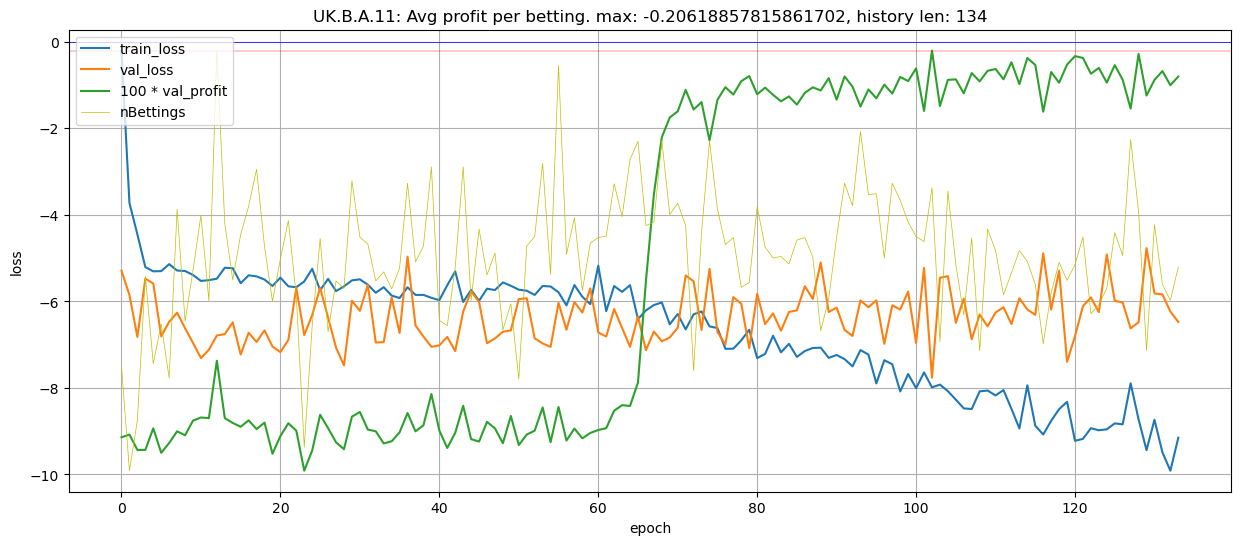

In [44]:
show_history(history, baseline=0)

In [45]:
epochs = 500;  prev_loss = float("inf")
for epoch in range(history.len(), epochs):
    start_time = time.time()
    m = 0; epoch_loss = 0.0
    n = 0; loss = tf.Variable(0.0, dtype=tf.float32); samples_seen = 0
    norm_pp_multiplier = epoch / NORM_PP_PATIENCY    # noralized_profit_pred_multiplier is scheduled here.

    baseId_1 = None
    train_batches = make_train_batches(train_ds)
    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(train_batches):
        if baseId_1 is None: baseId_1 = baseId[0]
        # print('train', sequence.shape)
        x = (sequence, base_bb, mask); y = base_label
        batch_loss = train_step(x, y, norm_pp_multiplier)
        n += 1; loss = loss * (n-1) / n + batch_loss / n
        m += 1; epoch_loss = epoch_loss * (m-1)/m + batch_loss / m

        samples_seen += sequence.shape[0]
        if step % 50 == 0:
            show_steps(epoch, step, loss, samples_seen)
            n = 0; loss = 0.0

    show_steps(epoch, step, loss, samples_seen)
    val_loss = test_with_dataset(test_batches, norm_pp_multiplier)
    profit_back_mean, nBettingsTotal = back_test_with_dataset(test_batches)
    # back2 = back_test_with_dataset2(test_batches)
    save_checkpoint(epoch_loss, val_loss, profit_back_mean, nBettingsTotal)     #------------------------------------------- comeback

    eM365W = EPL.layers[0].layers[0].get_weights()[6]; eM365W = list(tf.reshape(eM365W, (-1,)).numpy())
    # shift = tf.squeeze(EPL.layers[-1].get_weights()).numpy()
    # dM365W =EPL.layers[0].layers[1].get_weights()[4]; dM365W = list(tf.reshape(dM365W, (-1,)).numpy())

    print("epoch: {}, loss: {}, val_loss: {}, back_test: {}, nBettings: {}, baseId_1: {}, memory365: {:.4f},  time taken: {:.0f}s          "
          .format(epoch, float(epoch_loss), float(val_loss), float(profit_back_mean), nBettingsTotal, baseId_1, eM365W[0] * hyperparams.initial_m365, (time.time() - start_time)))

epoch: 134, loss: 1.7349779605865479, val_loss: 1.7402504682540894, back_test: -0.009795798920094967, nBettings: 1916, baseId_1: 122498, memory365: 0.8992,  time taken: 196s          
